# 3D Convolutional Neural Network for Tomographic Alignment

## Regular CNN

In order to test potential methods for performing automatic tomographic alignment using neural networks, we start with a standard model using a three dimensional convolution. The main problem with tomographic alignment is that a stack of two dimensional projections have to be processed simultameously for optimal results. While two dimensional convolutions can be used with channels corresponding with each projection angle, this is likely similar in computational complexity to a three dimensional neural network. Therefore the approach for this test is similar to video classification, where each frame in a video is is instead each projection angle.

In order to test if this method can provide a convergence, phantoms will be artificially misaligned to create a training and testing set. But first packages for tomography, image transformations, and neural networks have to be imported.

In [16]:
# Import essential packages
import os
import numpy as np
import matplotlib.pyplot as plt

# Import tomography and imaging packages
import tomopy
from skimage.transform import rotate, AffineTransform
from skimage import transform as tf

# Import neural net packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary

Since the model will be a computationally complex CNN, we must ensure that the GPU is being used for calculations or else computation will be far too slow.

In [17]:
# Checking to ensure environment and cuda are correct
print("Working Environment: {}".format(os.environ['CONDA_DEFAULT_ENV']))
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print("Cuda Version: {}".format(torch.version.cuda))
print("Cuda Availability: {}".format(torch.cuda.is_available()))

Working Environment: pytorch
Cuda Version: 11.8
Cuda Availability: True


Now that the packages have been imported and CUDA is set up correctly, the next step is to create the dataset to be used for training and testing the neural network. The misalignment function is created to perform different random misalignments on the phantom set of tomographic scans. The shape of all of the data is then checked for errors and the data is split into training and testing sets.

In [18]:
# Define function for artificial misalignment
def misalign(prj, mis_axis, ang_tilt = False, noise = False, background = False):
    num_prj, col, row = prj.shape
    dx = mis_axis[:, 0]
    dy = mis_axis[:, 1]
    prj_tmp = tomopy.shift_images(prj, dx, dy)
    
    for i in range(num_prj):
        d_row, d_col, d_ang = mis_axis[i]
        
        if ang_tilt == True:
            prj_tmp[i, :, :] = rotate(prj[i,:,:], d_ang)
        else:
            prj_tmp[i, :, :] = prj[i,:,:]
        
        if noise == True:
            prj_tmp[i, :, :] = random_noise(prj_tmp[i, :, :], mode = 'gaussian')
            
        if background == True:
            prj_tmp[i, :, :] = prj_tmp[i, :, :]+np.random.random()/5
            prj_tmp[i, :, :] = prj_tmp[i, :, :]/prj_tmp[i, :, :].max()  
            
    return prj_tmp

In [4]:
# Creating ground truth tomography
data = tomopy.shepp3d(256)
ang = tomopy.angles(180)
proj = tomopy.project(data, ang)

In [5]:
# Create dataset to store misaligned projections and 
entries = 120
dataset = np.zeros((entries, 2), dtype = object)

for i in range(entries):
    # Randomly determined misalignment axis
    mis_axis = np.random.normal(0, 1, (200, 3))
    mis_axis[:, :1] = mis_axis[:, :1]*4
    mis_axis = np.round(mis_axis).astype(int)
    mis_axis_in = np.expand_dims(mis_axis, axis = 0)
    
    proj_mis = misalign(proj.copy(), mis_axis, ang_tilt = True)
    proj_mis = np.expand_dims(proj_mis, axis = 0)
    proj_mis = np.expand_dims(proj_mis, axis = 0)
    
    dataset[i, 0] = proj_mis
    dataset[i, 1] = np.concatenate((mis_axis_in[:, :180, 0], mis_axis_in[:, :180, 1]), axis = 1)

In [6]:
# Checking shape of dataset
print(dataset.shape)
print(dataset[0].shape)
print(dataset[1].shape)
print(dataset[1][0].shape)
print(dataset[1][1].shape)

(120, 2)
(2,)
(2,)
(1, 1, 180, 256, 366)
(1, 360)


In [7]:
# Checking shape of training and testing splits
trainset, testset = np.split(dataset, [int(entries* 4 / 5)])
print(trainset.shape)
print(testset.shape)

(96, 2)
(24, 2)


Now that the data has been set up, the CUDA cache should be cleared and the model will be implemented.

In [19]:
torch.cuda.empty_cache()
print("Cleared Cache.")

Cleared Cache.


In [20]:
# Normalize data
def norm(proj):
    proj = (proj - torch.min(proj)) / (torch.max(proj) - torch.min(proj))
    return proj

# 3D CNN to determine shift parameters

class CNN_3D_aligner(nn.Module):
    def __init__(self):
        super(CNN_3D_aligner, self).__init__()

        self.group1 = nn.Sequential(
            nn.Conv3d(1, 45, kernel_size = (7, 7, 7), padding = 0), 
            nn.BatchNorm3d(45),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2)) 
        )
        
        self.group2 = nn.Sequential(
            nn.Conv3d(45, 90, kernel_size = (3, 3, 3), padding = 0), 
            nn.BatchNorm3d(90),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2)) 
        )
        
        self.group3 = nn.Sequential(
            nn.Conv3d(90, 180, kernel_size = (3, 3, 3), padding = 0), 
            nn.BatchNorm3d(180),
            nn.ReLU(),
            nn.Conv3d(180, 180, kernel_size = (3, 3, 3), padding = 0), 
            nn.BatchNorm3d(180),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2)) 
        )
        
        self.group4 = nn.Sequential(
            nn.Conv3d(180, 360, kernel_size = (3, 3, 3), padding = 0), 
            nn.BatchNorm3d(360),
            nn.ReLU(),
            nn.Conv3d(360, 360, kernel_size = (3, 3, 3), padding = 0), 
            nn.BatchNorm3d(360),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2)) 
        )
        
        self.group5 = nn.Sequential(
            nn.Conv3d(360, 720, kernel_size = (3, 3, 3), padding = 0), 
            nn.BatchNorm3d(720),
            nn.ReLU(),
            nn.Conv3d(720, 720, kernel_size = (3, 3, 3), padding = 0), 
            nn.BatchNorm3d(720),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2)) 
        )
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Sequential(
            nn.Linear(20160, 2016),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
        self.fc2 = nn.Linear(2016, 360)

    def forward(self, x):
        
        x = norm(x)
        
        x = self.group1(x)
        x = self.group2(x)
        x = self.group3(x)
        x = self.group4(x)
        x = self.group5(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In order to ensure the network works and understand its structure before training data on it, use the summary function in order to get an understanding of the network and fix any linear algebra errors in creating the neural network.

In [21]:
# Test model shape
model = CNN_3D_aligner()
summary(model, (1, 1, 180, 256, 366))

Layer (type:depth-idx)                   Output Shape              Param #
CNN_3D_aligner                           [1, 360]                  --
├─Sequential: 1-1                        [1, 45, 87, 125, 180]     --
│    └─Conv3d: 2-1                       [1, 45, 174, 250, 360]    15,480
│    └─BatchNorm3d: 2-2                  [1, 45, 174, 250, 360]    90
│    └─ReLU: 2-3                         [1, 45, 174, 250, 360]    --
│    └─MaxPool3d: 2-4                    [1, 45, 87, 125, 180]     --
├─Sequential: 1-2                        [1, 90, 42, 61, 89]       --
│    └─Conv3d: 2-5                       [1, 90, 85, 123, 178]     109,440
│    └─BatchNorm3d: 2-6                  [1, 90, 85, 123, 178]     180
│    └─ReLU: 2-7                         [1, 90, 85, 123, 178]     --
│    └─MaxPool3d: 2-8                    [1, 90, 42, 61, 89]       --
├─Sequential: 1-3                        [1, 180, 19, 28, 42]      --
│    └─Conv3d: 2-9                       [1, 180, 40, 59, 87]      437,580


Now the model can be trained, making sure to move all of the elements of the training process to the GPU to optimize computational speed.

In [22]:
# Train the model

# Create writer to analyze loss over each epoch
writer = SummaryWriter()

# Set device to CUDA if available, initialize model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device: {}'.format(device))
net = CNN_3D_aligner()
net.to(device)

# Set up optimizer and loss function, set number of epochs
optimizer = optim.SGD(net.parameters(), lr = 1e-3, momentum = 0.9)
criterion = nn.MSELoss(reduction = 'sum')
criterion.to(device)
num_epochs = 100

# Iniitializing variables to show statistics
iteration = 0
loss_list = []
epoch_loss_averages = []

# Iterates over dataset multiple times
for epoch in range(num_epochs):
    epoch_loss = 0
    for i, data in enumerate(trainset, 0):
        inputs, truths = norm(torch.from_numpy(data[0]).to(device)), torch.from_numpy(data[1]).to(device).float()
        optimizer.zero_grad()

        outputs = net(inputs).to(device)
        loss = criterion(outputs, truths)
        writer.add_scalar("Loss / Train", loss, epoch) # adds training loss scalar
        loss_list.append(loss.cpu().detach().numpy())
        epoch_loss += loss.cpu().detach().numpy()
        loss.backward()
        optimizer.step

        iteration += 1
        if iteration % trainset.shape[0] == 0:
            epoch_loss_averages.append(epoch_loss / trainset.shape[0])
            print('Iteration: {}   Loss: {} '.format(iteration, epoch_loss / trainset.shape[0]))
            
writer.flush()
writer.close()

Device: cuda:0
Iteration: 96   Loss: 3122.821088155111 
Iteration: 192   Loss: 3118.968236287435 
Iteration: 288   Loss: 3122.6758575439453 
Iteration: 384   Loss: 3120.5310974121094 
Iteration: 480   Loss: 3131.7755330403647 
Iteration: 576   Loss: 3128.817970275879 
Iteration: 672   Loss: 3119.9546686808267 
Iteration: 768   Loss: 3131.057139078776 
Iteration: 864   Loss: 3123.6515935262046 
Iteration: 960   Loss: 3125.0819244384766 
Iteration: 1056   Loss: 3127.9797719319663 
Iteration: 1152   Loss: 3127.232810974121 
Iteration: 1248   Loss: 3135.678136189779 
Iteration: 1344   Loss: 3128.9398905436196 
Iteration: 1440   Loss: 3123.9982884724936 
Iteration: 1536   Loss: 3120.574862162272 
Iteration: 1632   Loss: 3124.788993835449 
Iteration: 1728   Loss: 3122.528366088867 
Iteration: 1824   Loss: 3125.087448120117 
Iteration: 1920   Loss: 3128.7257944742837 
Iteration: 2016   Loss: 3125.0548299153647 
Iteration: 2112   Loss: 3125.3249028523765 
Iteration: 2208   Loss: 3132.949371337

Now in order to observe convergence or lack thereof graphs of loss per iteration as well as a moving average based on each epoch are created for analysis.

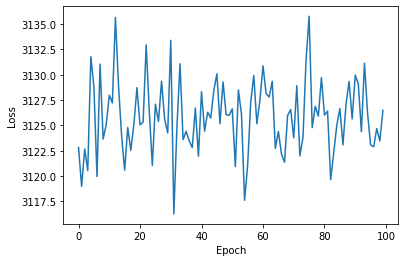

In [23]:
# Plot epoch loss to test for convergence
plt.plot(epoch_loss_averages)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

As seen above, this neural network fails to create convergence for the dataset. However, the fact that the loss does not stay completely constant is promising and it is possible that a deeper neural network can prove to solve this problem. The main restrictions at this point are memory allocation errors and different frameworks will have to be used in order to create a neural network with the depth necessary to observe convergence.